# Parametric ML and Bayesian regression

    Notebook version: 1.2 (Sep 28, 2018)

    Authors: Miguel Lázaro Gredilla
             Jerónimo Arenas García (jarenas@tsc.uc3m.es)
             Jesús Cid Sueiro (jesus.cid@uc3m.es)

    Changes: v.1.0 - First version. Python version
             v.1.1 - Python 3 compatibility. ML section.
             v.1.2 - Revised content. 2D visualization removed.
    
    Pending changes: 

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import scipy.io       # To read matlab files
from scipy import spatial
import pylab
pylab.rcParams['figure.figsize'] = 8, 5

## 1. Introduction

In this exercise the student will review several key concepts of Maximum Likelihood and Bayesian regression. To do so, we will assume the regression model

$$s = f({\bf x}) + \varepsilon$$

where $s$ is the output corresponding to input ${\bf x}$, $f({\bf x})$ is an unobservable latent function, and $\varepsilon$ is white zero-mean Gaussian noise, i.e., 

$$\varepsilon \sim {\cal N}(0,\sigma_\varepsilon^2).$$

In addition, we will assume that the latent function is *linear in the parameters*

$$f({\bf x}) = {\bf w}^\top {\bf z}$$

where ${\bf z} = T({\bf x})$ is a possibly non-linear transformation of the input. Along this notebook, we will explore different types of transformations.

Also, we will assume an <i>a priori</i> distribution for ${\bf w}$ given by

$${\bf w} \sim {\cal N}({\bf 0}, \sigma_p^2~{\bf I})$$



### Practical considerations

   - Though sometimes unavoidable, it is recommended not to use explicit matrix inversion whenever possible. For instance, if an operation like ${\mathbf A}^{-1} {\mathbf b}$ must be performed, it is preferable to code it using python $\mbox{numpy.linalg.lstsq}$ function (see http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html), which provides the LS solution to the overdetermined system ${\mathbf A} {\mathbf w} = {\mathbf b}$.
   
   - Sometimes, the computation of $\log|{\mathbf A}|$ (where ${\mathbf A}$ is a positive definite matrix) can overflow available precision, producing incorrect results. A numerically more stable alternative, providing the same result is $2\sum_i \log([{\mathbf L}]_{ii})$, where $\mathbf L$ is the Cholesky decomposition of $\mathbf A$ (i.e., ${\mathbf A} = {\mathbf L}^\top {\mathbf L}$), and $[{\mathbf L}]_{ii}$ is the $i$th element of the diagonal of ${\mathbf L}$.
   
   - Non-degenerate covariance matrices, such as the ones in this exercise, are always positive definite. It may happen, as a consequence of chained rounding errors, that a matrix which was mathematically expected to be positive definite, turns out not to be so. This implies its Cholesky decomposition will not be available. A quick way to palliate this problem is by adding a small number (such as $10^{-6}$) to the diagonal of such matrix.

### Reproducibility of computations

To guarantee the exact reproducibility of the experiments, it may be useful to start your code initializing the seed of the random numbers generator, so that you can compare your results with the ones given in this notebook.

In [2]:
np.random.seed(3)

## 2. Data generation with a linear model

During this section, we will assume affine transformation
$${\bf z} = T({\bf x}) = (1, {\bf x}^\top)^\top$$.

The <i>a priori</i> distribution of ${\bf w}$ is assumed to be

$${\bf w} \sim {\cal N}({\bf 0}, \sigma_p^2~{\bf I})$$

### 2.1. Synthetic data generation

First, we are going to generate synthetic data (so that we have the ground-truth model) and use them to make sure everything works correctly and our estimations are sensible.

* [1] Set parameters $\sigma_p^2 = 2$ and $\sigma_{\varepsilon}^2 = 0.2$. To do so, define variables `sigma_p` and `sigma_eps` containing the respectiv standard deviations.

In [3]:
# Parameter settings
# sigma_p = <FILL IN>
sigma_p = np.sqrt(2)
# sigma_eps = <FILL IN>
sigma_eps = np.sqrt(0.2)

* [2] Generate a weight vector $\mbox{true_w}$ with two elements from the <i>a priori</i> distribution of the weights. This vector determines the regression line that we want to find (i.e., the optimum unknown solution).

In [4]:
# Data dimension:
dim_x = 2

# Generate a parameter vector taking a random sample from the prior distributions
# (the np.random module may be usefull for this purpose)
# true_w = <FILL IN>
true_w = sigma_p * np.random.randn(dim_x, 1)

print('The true parameter vector is:')
print(true_w)

The true parameter vector is:
[[2.52950265]
 [0.61731815]]


* [3] Generate an input matrix ${\bf X}$ (in this case, a single column) containing 20 samples with equally spaced values between 0 and 2 in the second column (method `linspace` from numpy can be useful for this)

In [5]:
# <SOL>
# Parameter settings
x_min = 0
x_max = 2
n_points = 21

# Training datapoints
X = np.linspace(x_min, x_max, n_points)[:,np.newaxis]
# </SOL>

* [4] Finally, generate the output vector ${\mbox s}$ as the product $\mbox{X} \ast \mbox{true_w}$ plus Gaussian noise of pdf ${\cal N}(0,\sigma_\varepsilon^2)$ at each element.

In [6]:
# Expand input matrix with an all-ones column
col_1 = np.ones((n_points, 1))
# Z = <FILL IN>
Z = np.hstack((col_1,X))

# Generate values of the target variable
# s = <FILL IN>
s = np.dot(Z, true_w) + sigma_eps * np.random.randn(n_points, 1)

### 2.2. Data visualization

* Plot the generated data. You will notice a linear behavior, but the presence of noise makes it hard to estimate precisely the original straight line that generated them (which is stored in $\mbox{true_w}$).

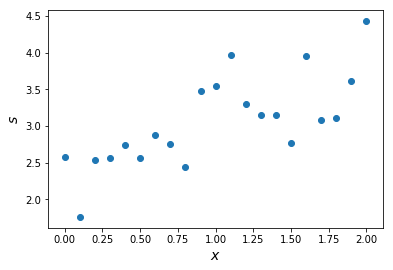

In [7]:
# <SOL> 
# Plot training points
plt.scatter(X, s);
plt.xlabel('$x$',fontsize=14);
plt.ylabel('$s$',fontsize=14);
# </SOL>

## 3. Maximum Likelihood (ML) regression

### 3.1. Likelihood function

* [1] Define a function `predict(we, Z)` that computes the linear predictions for all inputs in data matrix `Z` (a 2-D numpy arry), for a given parameter vector `we` (a 1-D numpy array). The output should be a 1-D array. Test your function with the given dataset and `we = [0.4, 0.7]`

In [8]:
# <SOL>
# Prediction function
def predict(Z, w):
    return Z.dot(w)

we = np.array([0.4, 0.7])
p = predict(Z, we)
# </SOL>

# Print predictions
print(p)

[0.4  0.47 0.54 0.61 0.68 0.75 0.82 0.89 0.96 1.03 1.1  1.17 1.24 1.31
 1.38 1.45 1.52 1.59 1.66 1.73 1.8 ]


* [2] Define a function `sse(we, Z, s)` that computes the sum of squared errors (SSE) for the linear prediction with parameters `we ` (1D numpy array), inputs `Z `  (2D numpy array) and targets `s ` (1D numpy array). Using this function, compute the SSE of the true parameter vector in `true_w`.

In [9]:
# <SOL>
# Sum of Squared Errors
def sse(Z, s, w):
    return np.sum((s - predict(Z, w))**2)

SSE = sse(Z, s, true_w)
# </SOL>

print(" The SSE is: {0}".format(SSE))

 The SSE is: 3.8420886935286145


* [3] Define a function `likelihood(we, Z, s, sigma_eps)` that computes the likelihood of parameter vector `we` for a given dataset in matrix `Z` and vector `s`, assuming Gaussian noise with varianze $\sigma_\epsilon^2$. Note that this function can use the `sse` function defined above. Using this function, compute the likelihood of the true parameter vector in `true_w`.

In [10]:
# <SOL>
# The plot: LHS is the data, RHS will be the cost function.
def likelihood(w, Z, s, sigma_eps):
    K = len(s)
    lw = 1.0 / (np.sqrt(2*np.pi)*sigma_eps)**K * np.exp(- sse(Z, s, w)/(2*sigma_eps**2))
    return lw

L_w_true = likelihood(true_w, Z, s, sigma_eps)
# </SOL>

print("The likelihood of the true parameter vector is {0}".format(L_w_true))

The likelihood of the true parameter vector is 6.120707579477163e-06


* [4] Define a function `LL(we, Xe, s)` that computes the log-likelihood of parameter vector `we` for a given dataset in matrix `Z` and vector `s`. Note that this function can use the `likelihood` function defined above. However, for a highe numerical precission, implemening a direct expression for the log-likelihood is recommended. 

   Using this function, compute the likelihood of the true parameter vector in `true_w`.

In [11]:
# <SOL>
# The plot: LHS is the data, RHS will be the cost function.
def LL(w, Z, s, sigma_eps):
    K = len(s)
    Lw = - K * np.log(np.sqrt(2*np.pi)*sigma_eps) - sse(Z, s, w)/(2*sigma_eps**2)
    return Lw

LL_w_true = LL(true_w, Z, s, sigma_eps)
# </SOL>

print("The log-likelihood of the true parameter vector is {0}".format(LL_w_true))

The log-likelihood of the true parameter vector is -12.003832850561606


### 3.2. ML estimate

* [1] Compute the ML estimate of $w_e$ given the data.

In [12]:
# <SOL>
w_ML, _, _, _ = np.linalg.lstsq(Z, s, rcond=None)
# </SOL>

print(w_ML)

[[2.33012392]
 [0.73283365]]


* [2] Compute the maximum likelihood, and the maximum log-likelihood.

In [13]:
# <SOL>
L_w_ML = likelihood(w_ML, Z, s, sigma_eps)
LL_w_ML = LL(w_ML, Z, s, sigma_eps)
# </SOL>

print('Maximum likelihood: {0}'.format(L_w_ML))
print('Maximum log-likelihood: {0}'.format(LL_w_ML))

Maximum likelihood: 1.1447611278561181e-05
Maximum log-likelihood: -11.377729471688335


Just as an illustration, the code below generates a set of points in a two dimensional grid going from $(-\sigma_p, -\sigma_p)$ to $(\sigma_p, \sigma_p)$, computes the log-likelihood for all these points and visualize them using a 2-dimensional plot. You can see the difference between the true value of the parameter ${\bf w}$ (black) and the ML estimate (red).

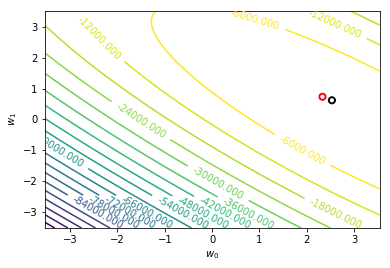

In [14]:
# First construct a grid of (theta0, theta1) parameter pairs and their
# corresponding cost function values.
N = 200    # Number of points along each dimension.
w0_grid = np.linspace(-2.5*sigma_p, 2.5*sigma_p, N)
w1_grid = np.linspace(-2.5*sigma_p, 2.5*sigma_p, N)

Lw = np.zeros((N,N))
# Fill Lw with the likelihood values
for i, w0i in enumerate(w0_grid):
    for j, w1j in enumerate(w1_grid):
        we = np.array((w0i, w1j)) 
        Lw[i, j] = LL(we, Z, s, sigma_eps)

WW0, WW1 = np.meshgrid(w0_grid, w1_grid, indexing='ij')
contours = plt.contour(WW0, WW1, Lw, 20)

plt.figure
plt.clabel(contours)
plt.scatter([true_w[0]]*2, [true_w[1]]*2, s=[50,10], color=['k','w'])
plt.scatter([w_ML[0]]*2, [w_ML[1]]*2, s=[50,10], color=['r','w'])
plt.xlabel('$w_0$')
plt.ylabel('$w_1$')
plt.show()

### 3.3. Convergence of the ML estimate for the true model

Note that the likelihood of the true parameter vector is, in general, smaller than that of the ML estimate. However, as the sample size increasis, both should converge to the same value.

* [1] Generate a longer dataset, with $K_\text{max}=2^{16}$ samples, uniformly spaces between 0 and 2. Store it in the 2D-array `X2` and the 1D-array `s2`

In [ ]:
# Parameter settings
x_min = 0
x_max = 2
n_points = 2**16

# <SOL>
# Training datapoints
X2 = np.linspace(x_min, x_max, n_points)

# Expand input matrix with an all-ones column
col_1 = np.ones((n_points,))
Xe2 = np.vstack((col_1, X2)).T
s2 = Xe2.dot(true_w) + sigma_eps * np.random.randn(n_points)
# </SOL>

* [2] Compute the ML estimate based on the first $2^k$ samples, for $k=2,3,\ldots, 16$. For each value of $k$ compute the squared euclidean distance between the true parameter vector and the ML estimate. Represent it graphically (using a logarithmic scale in the y-axis).

In [ ]:
# <SOL>
e2 = []
for k in range(3, 16):
    Xk = Xe2[0:2**k, :]
    sk = s2[0:2**k]

    w_MLk, _, _, _ = np.linalg.lstsq(Xk, sk)
    e2.append(np.sum((true_w - w_MLk)**2))

plt.semilogy(e2)
plt.show()
# </SOL>

## 4. ML estimation with real data. The stocks dataset.

Once our code has been tested on synthetic data, we will use it with real data. 

### 4.1. Dataset

* [1] Load data corresponding to the evolution of the stocks of 10 airline companies. This data set is an adaptation of the Stock dataset from http://www.dcc.fc.up.pt/~ltorgo/Regression/DataSets.html, which in turn was taken from the StatLib Repository, http://lib.stat.cmu.edu/

In [ ]:
# <SOL>
matvar = scipy.io.loadmat('DatosLabReg.mat')
Xtrain = matvar['Xtrain']
Xtest = matvar['Xtest']
Ytrain = matvar['Ytrain']
Ytest = matvar['Ytest']
# </SOL>

* [2] Normalize the data so all training sample components have zero mean and unit standard deviation. Store the normalized training and test samples in 2D numpy arrays `Xtrain` and `Xtest`, respectively.

In [ ]:
# <SOL>
# Data normalization
mean_x = np.mean(Xtrain,axis=0)
std_x = np.std(Xtrain,axis=0)
Xtrain = (Xtrain - mean_x) / std_x
Xtest = (Xtest - mean_x) / std_x
# </SOL>

### 4.2. Polynomial ML regression with a single variable

In this first part, we will work with the first component of the input only.

* [1] Take the first column of `Xtrain` and `Xtest` into arrays `X0train` and `X0test`, respectively. 

* [2] Visualize, in a single scatter plot, the target variable (in the vertical axes) versus the input variable)

* [3] Since the data have been taken from a real scenario, we do not have any *true* mathematical model of the process that generated the data. Thus, we will explore different models trying to take the one that fits better the training data.

  Assume a polinomial model given by
  $$
  {\bf z} = T({\bf x}) = (1, x_0, x_0^2, \ldots, x_0^{g-1})^\top.
  $$

  Built a method
  
     `    Ztrain, Ztest = T_poly(Xtrain, Xtest, g)`

  that, for a given value of $g$, computes normailzed data matrices `Ztrain` and `Ztest` that result from applying the polinomial transformation to the inputs in `X0train` and `X0test` for an arbitrary value of $g$.
  
  Note that, despite `X0train` and `X0test` where normalized, you will need to re-normalize the transformed variables.

In [ ]:
# <SOL>
# Extend input data matrices with a column of 1's
col_1 = np.ones((Xtrain.shape[0],1))
Ztrain = np.concatenate((col_1, Xtrain), axis = 1)

col_1 = np.ones((Xtest.shape[0],1))
Ztest = np.concatenate((col_1, Xtest), axis = 1)
# </SOL>

* [4] Fit a polynomial model with degree $g$ for $g$ ranging from 0 to 10. Store the weights of all models in a list of weight vectors, named `models`, such that `models[g]` returns the parameters estimated for the polynomial model with degree $g$. 

  We will use these models in the following sections.

* [5] Plot the polynomial models with degrees 1, 3 and 10, superimposed over a scatter plot of the training data (in blue) and the test data (in red).

* [6] Show, in the same plot:

  - The log-likelihood function corresponding to each model, as a function of $g$, computed over the training set.
  - The log-likelihood function corresponding to each model, as a function of $g$, computed over the test set.

* [7] [OPTIONAL] You may have seen the the likelihood function grows with the degree of the polynomial. However, large values of $g$ produce a strong data overfitting. For this reasong, $g$ cannot be selected with the same data used to fit the model. 

  This kind of parameters, like $g$ are usually called *hyperparameters* and need to be selected by cross validation.
  
  Another hyperparameter is $\sigma_\epsilon^2$. Plot the log-likelihood function corresponding to the polynomial model with degree 3 for different values of $\sigma_\epsilon^2$, for the training set and the test set. What would be the optimal value of this hyperparameters according to the training set?
  
  In any case, not that  the model coefficients do not depend on $\sigma_eps^2$. Therefore, we do not need to estimat its value for ML regression.

* [8] Select the optimal value of $g$ by cross-validation. To do so, the cross validation methods provided by sklearn will simplify this task.

* [9] For the selected model:

    - Plot the regresion function over the scater plot of the data.
    - Compute the log-likelihood and the SSE over the test set.

## 5. Bayesian regression. The stock dataset.

In this section we will keep using the first component of the data from the stock dataset, assuming the same kind of plolynomial model. We will explore the potential advantages of using a Bayesian model. To do so, we will asume that the <i>a priori</i> distribution of ${\bf w}$ is

$${\bf w} \sim {\cal N}({\bf 0}, \sigma_p^2~{\bf I})$$


### 5.1. Posterior pdf of the weight vector

In this section we will visualize prior and the posterior distribution functions. First, we will restore the dataset at the begining of this notebook:

* [1] Define a function `posterior_stats(Z, s, sigma_eps, sigma_p)` that computes the parameters of the posterior coefficient distribution given the dataset in matrix `Z` and vector `s`, for given values of the hyperparameters.
This function should return the posterior mean, the covariance matrix and the precision matrix (the inverse of the covariance matrix). Test the function to the given dataset, for $g=3$.

In [ ]:
# <SOL>
def posterior_stats(Z, s, sigma_eps, sigma_p):
    
    dim_w = Z.shape[1]    
    iCov_w = Z.T.dot(Z)/(sigma_eps**2) + np.eye(dim_w, dim_w)/(sigma_p**2)
    Cov_w = np.linalg.inv(iCov_w)
    mean_w = Cov_w.dot(Z.T).dot(s)/(sigma_eps**2) 

    return mean_w, Cov_w, iCov_w
# </SOL>

mean_w, Cov_w, iCov_w = posterior_stats(Z, s, sigma_eps, sigma_p)

print('true_w = {0}'.format(true_w))
print('mean_w = {0}'.format(mean_w))
print('Cov_w = {0}'.format(Cov_w))
print('iCov_w = {0}'.format(iCov_w))

* [2] Define a function `gauss_pdf(we, mean_w, iCov_w)` that computes the Gaussian pdf with mean `mean_w` and precision matrix `iCov_w`. Use this function to compute and compare the posterior pdf value of the true coefficients, the ML estimate and the MSE estimate, given the dataset.

In [ ]:
# <SOL>
def gauss_pdf(w, mean_w, iCov_w):

    d = w - mean_w
    w_dim = len(mean_w)
    pw = np.sqrt(np.linalg.det(iCov_w)) / (2*np.pi)**(w_dim/2) * np.exp(- d.T.dot(iCov_w.dot(d))/2)

    return pw
# </SOL>

print('p(true_w | s)  = {0}'.format(gauss_pdf(true_w, mean_w, iCov_w)))
print('p(w_ML | s)  = {0}'.format(gauss_pdf(w_ML, mean_w, iCov_w)))
print('p(w_MSE | s)  = {0}'.format(gauss_pdf(mean_w, mean_w, iCov_w)))

* [3] Define a function `log_gauss_pdf(we, mean_w, iCov_w)` that computes the log of the Gaussian pdf with mean `mean_w` and precision matrix `iCov_w`. Use this function to compute and compare the log of the posterior pdf value of the true coefficients, the ML estimate and the MSE estimate, given the dataset.

### 5.2. Hyperparameter selection

Since the values $\sigma_p$ and $\sigma_\varepsilon$ are no longer known, we have to select them in some way. To see their influence, assume $g=3$ and plot the regression function for different values of $\sigma_p$

To this end, we will adjust them using the LS solution to the regression problem:

   - $\sigma_p^2$ will be taken as the average of the square values of ${\hat {\bf w}}_{LS}$
   - $\sigma_\varepsilon^2$ will be taken as two times the average of the square of the residuals when using ${\hat {\bf w}}_{LS}$

### 5.1. Hyperparameter selection

Since the values $\sigma_p$ and $\sigma_\varepsilon$ are no longer known, a first rough estimation is needed (we will soon see how to estimate these values in a principled way).

To this end, we will adjust them using the LS solution to the regression problem:

   - $\sigma_p^2$ will be taken as the average of the square values of ${\hat {\bf w}}_{LS}$
   - $\sigma_\varepsilon^2$ will be taken as two times the average of the square of the residuals when using ${\hat {\bf w}}_{LS}$

In [ ]:
# w_LS, residuals, rank, s = <FILL IN>
w_LS, residuals, rank, s = np.linalg.lstsq(Ztrain, Ytrain)
# sigma_p = <FILL IN>
sigma_p = np.sqrt(np.mean(w_LS**2))
# sigma_eps = <FILL IN>
sigma_eps = np.sqrt(2*np.mean((Ytrain - Ztrain.dot(w_LS))**2))

print(sigma_eps)

### 5.2. Sampling regression curves from the posterior

In this section we will plot the functions corresponding to different samples drawn from the posterior distribution of the weight vector. 

To this end, we will first generate an input dataset of equally spaced samples. We will compute the functions at these points

In [ ]:
# Definition of the interval for representation purposes 
x2_min = -1
x2_max = 3
n_points = 100   # Only two points are needed to plot a straigh line

# Build the input data matrix:
# Input values for representation of the regression curves
X2 = np.linspace(x2_min, x2_max, n_points)
col_1 = np.ones((n_points,))
X2e = np.vstack((col_1, X2)).T

Generate random vectors ${\bf w}_l$ with $l = 1,\dots, 50$, from the posterior density of the weights, $p({\bf w}\mid{\bf s})$, and use them to generate 50 polinomial regression functions, $f({\bf x}^\ast) = {{\bf z}^\ast}^\top {\bf w}_l$, with ${\bf x}^\ast$ between $-1.2$ and $1.2$, with step $0.1$.

Plot the line corresponding to the model with the posterior mean parameters, along with the $50$ generated straight lines and the original samples, all in the same plot. As you can check, the Bayesian model is not providing a single answer, but instead a density over them, from which we have extracted 50 options.

In [ ]:
# Drawing weights from the posterior
# First, compute the cholesky decomposition of the covariance matrix
# L = <FILL IN>
L = np.linalg.cholesky(Cov_w)

for l in range(50):
    # Generate a random sample from the posterior distribution
    # w_l = <FILL IN>
    w_l = L.dot(np.random.randn(dim_x)) + mean_w

    # Compute predictions for the inputs in the data matrix
    # p_l = <FILL IN>
    p_l = X2e.dot(w_l)

    # Plot prediction function
    # plt.plot(<FILL IN>, 'c:');
    plt.plot(X2, p_l, 'c:');

# Compute predictions for the inputs in the data matrix and using the true model
# p_truew = <FILL IN>
p_truew = X2e.dot(true_w)

# Plot the true model
plt.plot(X2, p_truew, 'b', label='True model', linewidth=2);

# Plot the training points
plt.plot(X,s,'r.',markersize=12);

plt.xlim((x2_min,x2_max));
plt.legend(loc='best')
plt.xlabel('$x$',fontsize=14);
plt.ylabel('$s$',fontsize=14);

### 5.3. Plotting the confidence intervals

On top of the previous figure (copy here your code from the previous section), plot functions

$${\mathbb E}\left\{f({\bf x}^\ast)\mid{\bf s}\right\}$$

and

$${\mathbb E}\left\{f({\bf x}^\ast)\mid{\bf s}\right\} \pm 2 \sqrt{{\mathbb V}\left\{f({\bf x}^\ast)\mid{\bf s}\right\}}$$

(i.e., the posterior mean of $f({\bf x}^\ast)$, as well as two standard deviations above and below).

It is possible to show analytically that this region comprises $95.45\%$ probability of the posterior probability $p(f({\bf x}^\ast)\mid {\bf s})$ at each ${\bf x}^\ast$.

In [ ]:
# Note that you can re-use code from sect. 4.2 to solve this exercise

# Plot sample functions from the posterior, and the training points
# <SOL>
# Drawing weights from the posterior
for l in range(50):
    # Generate a random sample from the posterior distribution
    # w_l = <FILL IN>
    w_l = L.dot(np.random.randn(dim_x)) + mean_w

    # Compute predictions for the inputs in the data matrix
    # p_l = <FILL IN>
    p_l = X2e.dot(w_l)

    # Plot prediction function
    # plt.plot(<FILL IN>, 'c:');
    plt.plot(X2, X2e.dot(w_l), 'c:');

# Plot as well the training points and the true model
plt.plot(X2, X2e.dot(true_w), 'b', label='True model', linewidth=2);
plt.plot(X,s,'r.',markersize=12);
plt.xlim((x2_min,x2_max));
# </SOL>    

# Plot the posterior mean.
# mean_ast = <FILL IN>
mean_ast = X2e.dot(mean_w)
plt.plot(X2, mean_ast, 'm', label='Predictive mean', linewidth=2);

# Plot the posterior mean \pm 2 std
# std_ast = <FILL IN>
std_ast = np.sqrt(np.diagonal(X2e.dot(Cov_w).dot(X2e.T)))
# plt.plot(<FILL IN>, 'm--', label='Predictive mean $\pm$ 2std', linewidth=2);
plt.plot(X2, mean_ast+2*std_ast, 'm--', label='Predictive mean $\pm$ 2std', linewidth=2);
# plt.plot(<FILL IN>, 'm--', linewidth=3);
plt.plot(X2, mean_ast-2*std_ast, 'm--', linewidth=3);


plt.legend(loc='best')
plt.xlabel('$x$',fontsize=14);
plt.ylabel('$s$',fontsize=14);


Plot now ${\mathbb E}\left\{s({\bf x}^\ast)\mid{\bf s}\right\} \pm 2 \sqrt{{\mathbb V}\left\{s({\bf x}^\ast)\mid{\bf s}\right\}}$ (note that the posterior means of $f({\bf x}^\ast)$ and $s({\bf x}^\ast)$ are the same, so there is no need to plot it again). Notice that $95.45\%$ of observed data lie now within the newly designated region. These new limits establish a confidence range for our predictions. See how the uncertainty grows as we move away from the interpolation region to the extrapolation areas.

In [ ]:
# Plot sample functions confidence intervals and sampling points
# Note that you can simply copy and paste most of the code used in the cell above.

# <SOL>
# Plot sample functions from the posterior, and the training points
# Drawing weights from the posterior
for l in range(50):
    # Generate a random sample from the posterior distribution
    w_l = L.dot(np.random.randn(dim_x)) + mean_w

    # Compute predictions for the inputs in the data matrix
    p_l = X2e.dot(w_l)

    # Plot prediction function
    plt.plot(X2, X2e.dot(w_l), 'c:');

# Plot as well the training points and the true model
plt.plot(X2, X2e.dot(true_w), 'b', label='True model', linewidth=2);
plt.plot(X,s,'r.',markersize=12);
plt.xlim((x2_min,x2_max));

# Plot the posterior mean.
mean_ast = X2e.dot(mean_w)
plt.plot(X2, mean_ast, 'm', label='Predictive mean', linewidth=2);

# Plot the posterior mean \pm 2 std
std_ast = np.sqrt(np.diagonal(X2e.dot(Cov_w).dot(X2e.T)))
plt.plot(X2, mean_ast + 2*std_ast, 'm--', label='Predictive mean $\pm$ 2std', linewidth=2);
plt.plot(X2, mean_ast - 2*std_ast, 'm--', linewidth=3);
# </SOL>    

# Compute the standad deviations for s and plot the confidence intervals
# <SOL>
std_ast_eps = np.sqrt(np.diagonal(X2e.dot(Cov_w).dot(X2e.T)) + sigma_eps**2)
#Plot now the posterior mean and posterior mean \pm 2 std for s (i.e., adding the noise variance)
plt.plot(X2, mean_ast + 2*std_ast_eps, 'm:', label='Predictive mean of s $\pm$ 2std', linewidth=2);
plt.plot(X2, mean_ast - 2*std_ast_eps, 'm:', linewidth=2);
# </SOL>

plt.legend(loc='best')
plt.xlabel('$x$',fontsize=14);
plt.ylabel('$s$',fontsize=14);


### 5.3. Model assessment

[OPTIONAL. You can skip this section]

In order to verify the performance of the resulting model, compute the posterior mean and variance of each of the test outputs from the posterior over ${\bf w}$. I.e, compute ${\mathbb E}\left\{s({\bf x}^\ast)\mid{\bf s}\right\}$ and $\sqrt{{\mathbb V}\left\{s({\bf x}^\ast)\mid{\bf s}\right\}}$ for each test sample ${\bf x}^\ast$ contained in each row of `Xtest`. Be sure not to use the outputs `Ytest` at any point during this process.

Store the predictive mean and variance of all test samples in two column vectors called `m_y` and `v_y`, respectively.

In [ ]:
# <SOL>
m_y = Ztest.dot(mean_w)
v_y = np.diagonal(Ztest.dot(Cov_w).dot(Ztest.T)) + sigma_eps**2
v_y = np.matrix(v_y).T
# </SOL>

Compute now the mean square error (MSE) and the negative log-predictive density (NLPD) with the following code:

In [ ]:
# <SOL>
MSE = np.mean((m_y - Ytest)**2)
NLPD = 0.5 * np.mean(((Ytest - m_y)**2)/v_y) + 0.5*np.log(2*np.pi*v_y)
# </SOL>

Results should be:

In [ ]:
print('MSE = {0}'.format(MSE))
print('NLPD = {0}'.format(NLPD))

These two measures reveal the quality of our predictor (with lower values revealing higher quality). The first measure (MSE) only compares the predictive mean with the actual value and always has a positive value (if zero was reached, it would mean a perfect prediction). It does not take into account predictive variance. The second measure (NLPD) takes into account both the deviation and the predictive variance (uncertainty) to measure the quality of the probabilistic prediction (a high error in a prediction that was already known to have high variance has a smaller penalty, but also, announcing a high variance when the prediction error is small won’t award such a good score).

## 6. Regression with all variables from the stocks dataset.

Try to improve the performance of the best model used so far. To do so:

* Explore the use of all the input variables from the dataset.
* Explore other regression algorithms from the `sklearn` library.